In [ ]:
pip install transformers

In [2]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/678M [00:00<?, ?B/s]

In [3]:
import torch
import gc
import multiprocessing as mp
from tqdm import tqdm

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
df_1 = pd.read_csv('/content/drive/MyDrive/gr_1.csv')
df_1

,Unnamed: 0,value/0/#text,value/0/@_name,value/1/#text,value/1/@_name,value/2/#text,value/2/@_name,value/3/#text,value/3/@_name,value/4/#text,value/4/@_name,value/5/#text,value/5/@_name
0,5,25431,id,34533,id_1,34534,id_2,Вертолет с 11 иностранцами на борту упал в Пак...,text_1,В Пакистане упал вертолет с 11 иностранцами,text_2,1,class
1,6,25432,id,34535,id_1,34536,id_2,Самолет вернулся в аэропорт Новосибирска из-за...,text_1,Самолет вернулся в новосибирский аэропорт из-з...,text_2,1,class
2,9,25443,id,34556,id_1,34557,id_2,Суд оправдал Васильеву в хищении акций на два ...,text_1,Суд оправдал Васильеву в хищении акций на 2 мл...,text_2,1,class
3,10,25447,id,34560,id_1,34561,id_2,Пушков: у Обамы не хватило духа лично поздрави...,text_1,Пушков: Обама не нашел в себе духа лично поздр...,text_2,1,class
4,11,25448,id,34562,id_1,34563,id_2,МЧС РФ: тела погибших российских дипломатов до...,text_1,Тела погибших в Непале российских дипломатов д...,text_2,1,class
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,1913,28473,id,37587,id_1,37588,id_2,Источник в МИД: Россия ввела визовые ограничен...,text_1,Визовые ограничения со стороны России стали от...,text_2,1,class
370,1915,28479,id,37584,id_1,37593,id_2,Саркози раскритиковал Олланда за отказ от посе...,text_1,Саркози осудил отказ Олланда приехать в Москву...,text_2,1,class
371,1916,28481,id,37594,id_1,37595,id_2,Почти 30 человек стали жертвами взрыва в мечет...,text_1,Не менее 26 человек погибли в результате терак...,text_2,1,class
372,1918,28483,id,37596,id_1,37597,id_2,Пушков: Саакашвили в Грузии мог бы возглавить ...,text_1,Пушков заявил о способности Саакашвили возглав...,text_2,1,class


In [6]:
sentences1 = df_1['value/3/#text'].tolist()
sentences2 = df_1['value/4/#text'].tolist()

In [7]:
cos = torch.nn.CosineSimilarity(dim=1)

In [8]:
%%time
DF_FILE = '/content/drive/MyDrive/gr_1.csv'
# размер одного обрабатываемого кусочка датафрейма
CHUNKSIZE = 20

def process_frame(df_1):
  # функция принимает на вход датафрейм и возвращает косинусные подобия для каждого ряда
  similarities_1 = []
  for n, row in tqdm(df_1.iterrows()):
    s = row['value/3/#text']
    t = row['value/4/#text']
    tokens_s = tokenizer([s], return_tensors="pt", padding=True)
    tokens_t = tokenizer([t], return_tensors="pt", padding=True)
    out_s = model(**tokens_s)
    out_t = model(**tokens_t)
    vec_s = torch.mean(out_s.last_hidden_state, dim=1)
    vec_t = torch.mean(out_t.last_hidden_state, dim=1)
    cos_sim = cos(vec_s, vec_t)
    # item() превращает тензор во float
    similarities_1.append(cos_sim.item())
    # на всякий случай собираем ненужное при помощи garbage collector
    gc.collect()
  return similarities_1

# читаем файл по кусочкам заданного размера
reader = pd.read_csv(DF_FILE, chunksize=CHUNKSIZE)
# количество процессов, которые могут идти одновременно
pool = mp.Pool(4)

funclist_1 = []
for df_1_new in reader:
  # открываем и обрабатываем каждый кусочек
  df_1.columns = ['Unnamed:', 'value/0/#text', 'value/0/@_name', 'value/1/#text', 'value/1/@_name', 'value/2/#text', 'value/2/@_name', 'value/3/#text', 'value/3/@_name', 'value/4/#text', 'value/4/@_name', 'value/5/#text', 'value/5/@_name']
  f = pool.apply_async(process_frame, [df_1_new])
  funclist_1.append(f)

result_1 = []
for f in funclist_1:
  # таймаут можно увеличить, если возникает ошибка
  sims = f.get(timeout=500)
  result_1.extend(sims)

20it [00:22,  1.12s/it]
20it [00:22,  1.14s/it]
20it [00:22,  1.14s/it]
20it [00:23,  1.15s/it]
20it [00:21,  1.09s/it]
20it [00:21,  1.10s/it]
20it [00:22,  1.12s/it]
20it [00:22,  1.13s/it]
20it [00:21,  1.09s/it]
20it [00:22,  1.11s/it]
20it [00:22,  1.11s/it]
20it [00:22,  1.11s/it]
20it [00:24,  1.23s/it]
20it [00:24,  1.25s/it]
20it [00:24,  1.23s/it]
20it [00:24,  1.22s/it]
14it [00:11,  1.20it/s]
20it [00:17,  1.13it/s]
20it [00:17,  1.16it/s]


CPU times: user 1.76 s, sys: 393 ms, total: 2.15 s
Wall time: 1min 49s


In [10]:
result_1[:374]

[0.9487786293029785,
 0.9289212822914124,
 0.9916914105415344,
 0.945438027381897,
 0.9686602354049683,
 0.9507191181182861,
 0.9566179513931274,
 0.9435794353485107,
 0.9667825698852539,
 0.9553046226501465,
 0.990045964717865,
 0.8894792199134827,
 0.9574681520462036,
 0.9921319484710693,
 0.939279317855835,
 0.9252301454544067,
 0.8976436853408813,
 0.9932219386100769,
 0.9796196222305298,
 0.9738802313804626,
 0.9456971287727356,
 0.9708596467971802,
 0.9315253496170044,
 0.964532196521759,
 0.9597419500350952,
 0.9597419500350952,
 0.910041868686676,
 0.8903697729110718,
 0.9354344010353088,
 0.980276346206665,
 0.9162464737892151,
 0.9838999509811401,
 0.9858967661857605,
 0.9720479249954224,
 0.9589880108833313,
 0.9589641690254211,
 0.9005830883979797,
 0.9254174828529358,
 0.981025755405426,
 0.9585359692573547,
 0.9646013975143433,
 0.9848247170448303,
 0.8610792756080627,
 0.9882227182388306,
 0.9730101823806763,
 0.9743837118148804,
 0.8709113597869873,
 0.926957368850708,


In [11]:
import numpy as np
np.mean(np.array(result_1))

0.9439571479106332

In [12]:
np.std(np.array(result_1))

0.0501561482992784

In [13]:
df_2 = pd.read_csv('/content/drive/MyDrive/gr_0.csv')
df_2

,Unnamed: 0,value/0/#text,value/0/@_name,value/1/#text,value/1/@_name,value/2/#text,value/2/@_name,value/3/#text,value/3/@_name,value/4/#text,value/4/@_name,value/5/#text,value/5/@_name
0,7,25438,id,34547,id_1,34546,id_2,Васильева признана виновной в мошенничестве и ...,text_1,Васильева признана виновной в хищениях и отмыв...,text_2,0,class
1,13,25456,id,34567,id_1,34568,id_2,Троих подростков-убийц поймали в Подмосковье,text_1,В Подмосковье трое подростков признались в сер...,text_2,0,class
2,20,25477,id,34590,id_1,34589,id_2,Лидер либдемов Ник Клегг подал в отставку посл...,text_1,Лидер британских лейбористов подал в отставку ...,text_2,0,class
3,26,25491,id,34605,id_1,34603,id_2,Консерваторы увеличили отрыв от лейбористов на...,text_1,Консерваторы победили на выборах в Британии,text_2,0,class
4,27,25492,id,34606,id_1,34607,id_2,Лавров о возможной встрече с Керри: готов встр...,text_1,Лавров заявил о готовности встретиться с Керри...,text_2,0,class
...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,1903,28455,id,37516,id_1,37566,id_2,В аэропортах Москвы из-за грозы задержаны и от...,text_1,Более 150 авиарейсов отменили в московских аэр...,text_2,0,class
774,1904,28456,id,37567,id_1,37568,id_2,Объекты инфраструктуры для ВС России в Арктике...,text_1,Все объекты военной инфраструктуры в Арктике с...,text_2,0,class
775,1910,28466,id,37574,id_1,37575,id_2,Пушилин назвал насмешкой над Украиной назначен...,text_1,Медведев назвал назначение Саакашвили «продолж...,text_2,0,class
776,1914,28475,id,37591,id_1,37590,id_2,Россия планирует создать войска быстрого реаги...,text_1,В России появятся войска быстрого реагирования...,text_2,0,class


In [14]:
sentences3 = df_2['value/3/#text'].tolist()
sentences4 = df_2['value/4/#text'].tolist()

In [15]:
cos = torch.nn.CosineSimilarity(dim=1)

In [16]:
%%time
DF_FILE = '/content/drive/MyDrive/gr_0.csv'
# размер одного обрабатываемого кусочка датафрейма
CHUNKSIZE = 20

def process_frame(df_2):
  # функция принимает на вход датафрейм и возвращает косинусные подобия для каждого ряда
  similarities_2 = []
  for n, row in tqdm(df_2.iterrows()):
    s = row['value/3/#text']
    t = row['value/4/#text']
    tokens_s = tokenizer([s], return_tensors="pt", padding=True)
    tokens_t = tokenizer([t], return_tensors="pt", padding=True)
    out_s = model(**tokens_s)
    out_t = model(**tokens_t)
    vec_s = torch.mean(out_s.last_hidden_state, dim=1)
    vec_t = torch.mean(out_t.last_hidden_state, dim=1)
    cos_sim = cos(vec_s, vec_t)
    # item() превращает тензор во float
    similarities_2.append(cos_sim.item())
    # на всякий случай собираем ненужное при помощи garbage collector
    gc.collect()
  return similarities_2

# читаем файл по кусочкам заданного размера
reader = pd.read_csv(DF_FILE, chunksize=CHUNKSIZE)
# количество процессов, которые могут идти одновременно
pool = mp.Pool(4)

funclist_2 = []
for df_2_new in reader:
  # открываем и обрабатываем каждый кусочек
  df_2.columns = ['Unnamed:', 'value/0/#text', 'value/0/@_name', 'value/1/#text', 'value/1/@_name', 'value/2/#text', 'value/2/@_name', 'value/3/#text', 'value/3/@_name', 'value/4/#text', 'value/4/@_name', 'value/5/#text', 'value/5/@_name']
  f = pool.apply_async(process_frame, [df_2_new])
  funclist_2.append(f)

result_2 = []
for f in funclist_2:
  # таймаут можно увеличить, если возникает ошибка
  sims = f.get(timeout=500)
  result_2.extend(sims)

20it [01:02,  3.13s/it]
20it [01:02,  3.14s/it]
20it [01:03,  3.15s/it]
20it [01:04,  3.24s/it]
20it [01:00,  3.00s/it]
20it [01:00,  3.01s/it]
20it [01:02,  3.11s/it]
20it [01:00,  3.04s/it]
20it [01:02,  3.13s/it]
20it [01:02,  3.15s/it]
20it [01:02,  3.13s/it]
20it [01:02,  3.10s/it]
20it [01:01,  3.06s/it]
20it [00:59,  2.97s/it]
20it [01:01,  3.10s/it]
20it [01:02,  3.10s/it]
20it [01:00,  3.05s/it]
20it [01:01,  3.08s/it]
20it [00:59,  2.96s/it]
20it [01:02,  3.12s/it]
20it [00:59,  2.95s/it]
20it [00:59,  2.98s/it]
20it [01:02,  3.13s/it]
20it [00:59,  3.00s/it]
20it [00:59,  2.97s/it]
20it [01:00,  3.04s/it]
20it [01:00,  3.04s/it]
20it [01:02,  3.11s/it]
20it [01:02,  3.15s/it]
20it [01:02,  3.13s/it]
20it [01:01,  3.09s/it]
20it [01:01,  3.10s/it]
20it [00:59,  2.96s/it]
20it [01:00,  3.04s/it]
20it [01:00,  3.01s/it]
20it [01:01,  3.07s/it]
18it [00:41,  2.29s/it]
20it [00:45,  2.28s/it]
20it [00:44,  2.25s/it]


CPU times: user 13 s, sys: 3.75 s, total: 16.8 s
Wall time: 9min 57s


In [18]:
result_2[:778]

[0.9673169851303101,
 0.8780003190040588,
 0.9280327558517456,
 0.8666228652000427,
 0.8423301577568054,
 0.7951082587242126,
 0.8656527996063232,
 0.8521560430526733,
 0.7742566466331482,
 0.9045712947845459,
 0.870735764503479,
 0.7030318379402161,
 0.8750737905502319,
 0.9445750117301941,
 0.999215304851532,
 0.9679193496704102,
 0.9690147042274475,
 0.9285331964492798,
 0.8840817213058472,
 0.8814831972122192,
 0.9354602694511414,
 0.8444260954856873,
 0.8877227902412415,
 0.7210331559181213,
 0.8402516841888428,
 0.9385322332382202,
 0.973495602607727,
 0.8717649579048157,
 0.9532985091209412,
 0.9136590361595154,
 0.9799421429634094,
 0.8234303593635559,
 0.9559969902038574,
 0.8819779753684998,
 0.9041500687599182,
 0.7271081209182739,
 0.9683777093887329,
 0.5324769020080566,
 0.6318572759628296,
 0.9297758340835571,
 0.9516903162002563,
 0.8366200923919678,
 0.8781743049621582,
 0.9052972197532654,
 0.9560068845748901,
 0.8886939883232117,
 0.84527987241745,
 0.878151416778564

In [19]:
np.mean(np.array(result_2))

0.8931577214468415

In [20]:
np.std(np.array(result_2))

0.07310552116902

In [21]:
df_3 = pd.read_csv('/content/drive/MyDrive/gr_-1.csv')
df_3

,Unnamed: 0,value/0/#text,value/0/@_name,value/1/#text,value/1/@_name,value/2/#text,value/2/@_name,value/3/#text,value/3/@_name,value/4/#text,value/4/@_name,value/5/#text,value/5/@_name
0,0,25349,id,34420,id_1,34421,id_2,Цены на нефть восстанавливаются,text_1,Парламент Словакии поблагодарил народы бывшего...,text_2,-1,class
1,1,25360,id,34438,id_1,34439,id_2,"""Гоголь-центр"" покажет видеозапись скандальног...",text_1,Кехман запретил «Гоголь-центру» показывать вид...,text_2,-1,class
2,2,25382,id,34475,id_1,34476,id_2,Агент: РФС вновь задерживает зарплату Фабио Ка...,text_1,СМИ: Агент Фабио Капелло грозится подать в суд...,text_2,-1,class
3,3,25423,id,34494,id_1,34519,id_2,День Победы в Москве обещает выдаться облачным,text_1,Любляна отпразднует День Победы вместе с Москвой,text_2,-1,class
4,4,25430,id,34531,id_1,34532,id_2,Посол РФ в США: Россия будет бороться с попытк...,text_1,Правительство запланировало заработать на лоте...,text_2,-1,class
...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,1909,28464,id,37477,id_1,37572,id_2,Саакашвили может стать губернатором Одесской о...,text_1,Медведев назвал назвачение Саакашвили одесским...,text_2,-1,class
768,1917,28482,id,37501,id_1,37595,id_2,Шестнадцать человек погибли в результате авари...,text_1,Не менее 26 человек погибли в результате терак...,text_2,-1,class
769,1921,28499,id,37606,id_1,37618,id_2,Полицейские в США застрелили афроамериканца в ...,text_1,Полицейский в США спас мужчину от наводнения и...,text_2,-1,class
770,1922,28510,id,37604,id_1,37636,id_2,"Полицейский в США спас мужчину от наводнения, ...",text_1,Washington Post: В 2015 году полицейские США з...,text_2,-1,class


In [23]:
sentences5 = df_3['value/3/#text'].tolist()
sentences6 = df_3['value/4/#text'].tolist()

In [24]:
cos = torch.nn.CosineSimilarity(dim=1)

In [25]:
%%time
DF_FILE = '/content/drive/MyDrive/gr_-1.csv'
# размер одного обрабатываемого кусочка датафрейма
CHUNKSIZE = 20

def process_frame(df_3):
  # функция принимает на вход датафрейм и возвращает косинусные подобия для каждого ряда
  similarities_3 = []
  for n, row in tqdm(df_3.iterrows()):
    s = row['value/3/#text']
    t = row['value/4/#text']
    tokens_s = tokenizer([s], return_tensors="pt", padding=True)
    tokens_t = tokenizer([t], return_tensors="pt", padding=True)
    out_s = model(**tokens_s)
    out_t = model(**tokens_t)
    vec_s = torch.mean(out_s.last_hidden_state, dim=1)
    vec_t = torch.mean(out_t.last_hidden_state, dim=1)
    cos_sim = cos(vec_s, vec_t)
    # item() превращает тензор во float
    similarities_3.append(cos_sim.item())
    # на всякий случай собираем ненужное при помощи garbage collector
    gc.collect()
  return similarities_3

# читаем файл по кусочкам заданного размера
reader = pd.read_csv(DF_FILE, chunksize=CHUNKSIZE)
# количество процессов, которые могут идти одновременно
pool = mp.Pool(4)

funclist_3 = []
for df_3_new in reader:
  # открываем и обрабатываем каждый кусочек
  df_3.columns = ['Unnamed:', 'value/0/#text', 'value/0/@_name', 'value/1/#text', 'value/1/@_name', 'value/2/#text', 'value/2/@_name', 'value/3/#text', 'value/3/@_name', 'value/4/#text', 'value/4/@_name', 'value/5/#text', 'value/5/@_name']
  f = pool.apply_async(process_frame, [df_3_new])
  funclist_3.append(f)

result_3 = []
for f in funclist_3:
  # таймаут можно увеличить, если возникает ошибка
  sims = f.get(timeout=500)
  result_3.extend(sims)

20it [01:10,  3.52s/it]
20it [01:10,  3.52s/it]
20it [01:11,  3.57s/it]
20it [01:13,  3.65s/it]
20it [01:03,  3.16s/it]
20it [01:04,  3.23s/it]
20it [01:06,  3.30s/it]
20it [01:03,  3.20s/it]
20it [00:58,  2.93s/it]
20it [01:01,  3.08s/it]
20it [01:00,  3.03s/it]
20it [01:02,  3.14s/it]
20it [01:01,  3.05s/it]
20it [01:01,  3.08s/it]
20it [01:01,  3.08s/it]
20it [00:59,  2.98s/it]
20it [01:01,  3.08s/it]
20it [00:59,  2.97s/it]
20it [01:01,  3.06s/it]
20it [01:01,  3.06s/it]
20it [01:01,  3.07s/it]
20it [01:02,  3.10s/it]
20it [01:01,  3.09s/it]
20it [01:03,  3.15s/it]
20it [00:58,  2.95s/it]
20it [00:59,  2.95s/it]
20it [01:01,  3.07s/it]
20it [01:01,  3.07s/it]
20it [01:00,  3.01s/it]
20it [00:59,  2.98s/it]
20it [00:59,  2.99s/it]
20it [01:01,  3.08s/it]
20it [01:01,  3.08s/it]
20it [00:59,  2.99s/it]
20it [01:01,  3.08s/it]
20it [00:59,  2.98s/it]
12it [00:26,  2.20s/it]
20it [00:41,  2.05s/it]
20it [00:38,  1.94s/it]


CPU times: user 13.5 s, sys: 3.79 s, total: 17.3 s
Wall time: 10min 1s


In [27]:
result_3[:772]

[0.5122355222702026,
 0.7783835530281067,
 0.7754808664321899,
 0.5538349151611328,
 0.41615384817123413,
 0.46173056960105896,
 0.7750599384307861,
 0.7885730862617493,
 0.6960771083831787,
 0.8978448510169983,
 0.8380513787269592,
 0.7062276005744934,
 0.7945903539657593,
 0.4769400358200073,
 0.7547872066497803,
 0.4772286117076874,
 0.8434537649154663,
 0.886619508266449,
 0.7842698693275452,
 0.7223402857780457,
 0.483646035194397,
 0.4090057611465454,
 0.4528926908969879,
 0.6975414156913757,
 0.7850059866905212,
 0.8052643537521362,
 0.566430926322937,
 0.6209134459495544,
 0.7841126918792725,
 0.8958374261856079,
 0.8177375197410583,
 0.6871801614761353,
 0.603717565536499,
 0.9351473450660706,
 0.7572539448738098,
 0.5797308087348938,
 0.8333690166473389,
 0.776386559009552,
 0.7291077375411987,
 0.6349605917930603,
 0.9199802279472351,
 0.777326226234436,
 0.763751208782196,
 0.635200560092926,
 0.8358480334281921,
 0.7861574292182922,
 0.86207515001297,
 0.8592454195022583,


In [28]:
np.mean(np.array(result_3))

0.7661156729635797

In [29]:
np.std(np.array(result_3))

0.13396752524021682

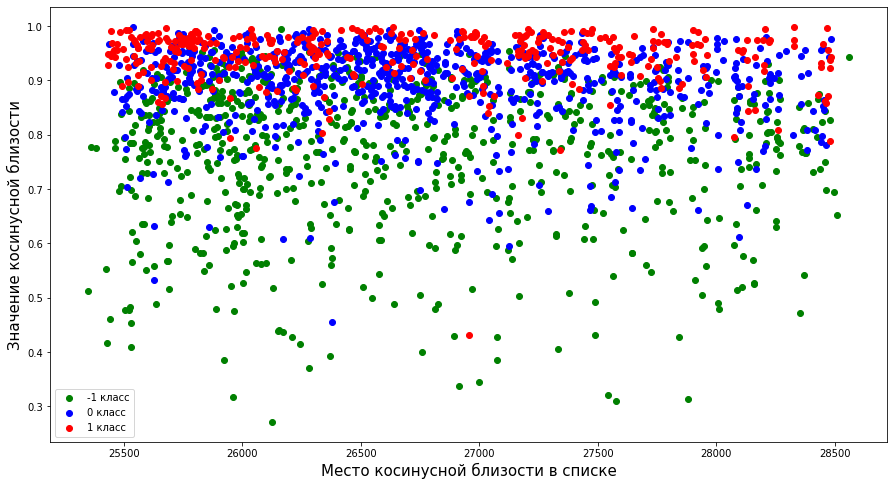

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))

x1 = df_1['value/0/#text'].tolist()
y1 = result_1

x2 = df_2['value/0/#text'].tolist()
y2 = result_2

x3 = df_3['value/0/#text'].tolist()
y3 = result_3

ax.scatter(x3, y3, color = 'green', label = '-1 класс')
ax.scatter(x2, y2, color = 'blue', label = '0 класс')
ax.scatter(x1, y1, color = 'red', label = '1 класс')

ax.legend()

plt.xlabel("Место косинусной близости в списке", fontsize = 15)
plt.ylabel("Значение косинусной близости", fontsize = 15)

plt.show()